# Imports and Setup:


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import cv2
import os
import xml.etree.ElementTree as ET
from PIL import Image
from collections import Counter



In [5]:
base_dir = os.getcwd()
images_dir = os.path.join(base_dir, "JPEGImages")
annotations_dir = os.path.join(base_dir, "Annotations")
# splits_dir = os.path.join(base_dir, "ImageSets", "Main")
splits_dir = base_dir

base_dir


'/Users/danyaalsadiq/Downloads/DL_Group_5'

In [20]:
# Define the splits
splits = ["train", "val", "test"]

# Check the number of images in each split
for split in splits:
    split_path = os.path.join(base_dir, f"{split}.txt")
    
    with open(split_path, "r") as f:
        image_ids = f.read().strip().split()

    print(f"{split.capitalize()} set contains {len(image_ids)} images.")

Train set contains 26991 images.
Val set contains 3829 images.
Test set contains 7500 images.


## Cleaning the Data

The train, val and test splits need to be cleaned since they have got missing entries. 

In [21]:
splits = ["train", "val", "test"]

# Function to check if annotation exists for an image
def has_annotation(image_id):
    annotation_file = os.path.join(annotations_dir, f"{image_id.zfill(5)}.xml")
    return os.path.exists(annotation_file)

# Function to check if image exists in JPEGImages
def has_image(image_id):
    image_file = os.path.join(images_dir, f"{image_id.zfill(5)}.jpg")
    return os.path.exists(image_file)

# Function to read and clean each split
def clean_split(split_name, all_valid_ids):
    print(f"\nCleaning {split_name}.txt...")
    split_file = os.path.join(splits_dir, f"{split_name}.txt")

    # Read image IDs from the split file
    with open(split_file, "r") as f:
        image_ids = f.read().strip().split()

    valid_ids = []
    invalid_ids = []
    
    # Check for missing images and annotations
    for image_id in image_ids:
        if has_image(image_id) and has_annotation(image_id):
            if image_id not in all_valid_ids:  # Ensure no duplicates across splits
                valid_ids.append(image_id)
                all_valid_ids.add(image_id)  # Add to the set of all valid IDs
            else:
                print(f"Duplicate found across splits: {image_id}")
        else:
            invalid_ids.append(image_id)

    # Save the cleaned split file
    clean_split_file = os.path.join(splits_dir, f"clean_{split_name}.txt")
    with open(clean_split_file, "w") as f:
        for image_id in valid_ids:
            f.write(image_id + "\n")
    
    print(f"Cleaned {split_name}.txt - {len(valid_ids)} valid entries.")
    if invalid_ids:
        print(f"Missing annotations or images for {len(invalid_ids)} entries.")
        for invalid_id in invalid_ids[:10]:  # Display only first 10 invalids
            print(f" - {invalid_id}")
        if len(invalid_ids) > 10:
            print(f"... and {len(invalid_ids) - 10} more.")
    
    return valid_ids, invalid_ids

# Function to remove duplicates between splits
def remove_duplicates_between_splits():
    all_valid_ids = set()  # To track valid IDs across all splits
    
    # Clean each split
    for split in splits:
        valid_ids, invalid_ids = clean_split(split, all_valid_ids)
    
    print("\nDataset cleaning completed.")
    print("Cleaned splits: clean_train.txt, clean_val.txt, clean_test.txt")

# Execute the cleaning process
remove_duplicates_between_splits()



Cleaning train.txt...
Cleaned train.txt - 12340 valid entries.
Missing annotations or images for 14651 entries.
 - 7
 - 16
 - 26
 - 35
 - 44
 - 60
 - 61
 - 65
 - 68
 - 90
... and 14641 more.

Cleaning val.txt...
Cleaned val.txt - 1690 valid entries.
Missing annotations or images for 2139 entries.
 - 2
 - 9
 - 119
 - 171
 - 192
 - 231
 - 232
 - 248
 - 339
 - 393
... and 2129 more.

Cleaning test.txt...
Cleaned test.txt - 3372 valid entries.
Missing annotations or images for 4128 entries.
 - 0
 - 12
 - 94
 - 139
 - 164
 - 179
 - 186
 - 190
 - 194
 - 201
... and 4118 more.

Dataset cleaning completed.
Cleaned splits: clean_train.txt, clean_val.txt, clean_test.txt


In [22]:
clean_splits = ["clean_train", "clean_val", "clean_test"]

for split in clean_splits:
    split_path = os.path.join(splits_dir, f"{split}.txt")
    
    with open(split_path, "r") as f:
        image_ids = f.read().strip().split()

    print(f"{split.capitalize()} set contains {len(image_ids)} images.")

Clean_train set contains 12340 images.
Clean_val set contains 1690 images.
Clean_test set contains 3372 images.


In [23]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = []
    for obj in root.findall("object"):
        name = obj.find("name").text
        bndbox = obj.find("bndbox")
        bbox = (
            int(bndbox.find("xmin").text),
            int(bndbox.find("ymin").text),
            int(bndbox.find("xmax").text),
            int(bndbox.find("ymax").text)
        )
        objects.append((name, bbox))
    return objects

def show_image_with_boxes(image_file, annotation_file, image_id):
    image = Image.open(image_file)
    objects = parse_annotation(annotation_file)

    plt.figure(figsize=(10, 10))
    plt.title(image_id)
    plt.imshow(image)
    ax = plt.gca()

    for name, (xmin, ymin, xmax, ymax) in objects:
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, edgecolor='red', linewidth=2))
        ax.text(xmin, ymin - 5, name, color='white', fontsize=12,
                bbox=dict(facecolor='red', edgecolor='none', pad=1))
    plt.axis('off')
    plt.show()


In [24]:
# def print_tree(element, level=0):
#     print("  " * level + f"<{element.tag}>")
#     for child in element:
#         print_tree(child, level + 1)
import xml.etree.ElementTree as ET
tree = ET.parse('Annotations/00001.xml')
root = tree.getroot()

def print_element(elem, level=0):
    indent = "  " * level
    print(f"{indent}{elem.tag}: {elem.text.strip() if elem.text and elem.text.strip() else ''}")
    for child in elem:
        print_element(child, level + 1)

# Print the entire tree
print_element(root)


# print(root.findall("object"))
# print_tree(root)

annotation: 
  filename: 00001.jpg
  source: 
    database: DIOR
  size: 
    width: 800
    height: 800
    depth: 3
  segmented: 0
  object: 
    name: golffield
    pose: Unspecified
    bndbox: 
      xmin: 133
      ymin: 237
      xmax: 684
      ymax: 672
    description: A green and brown golf field


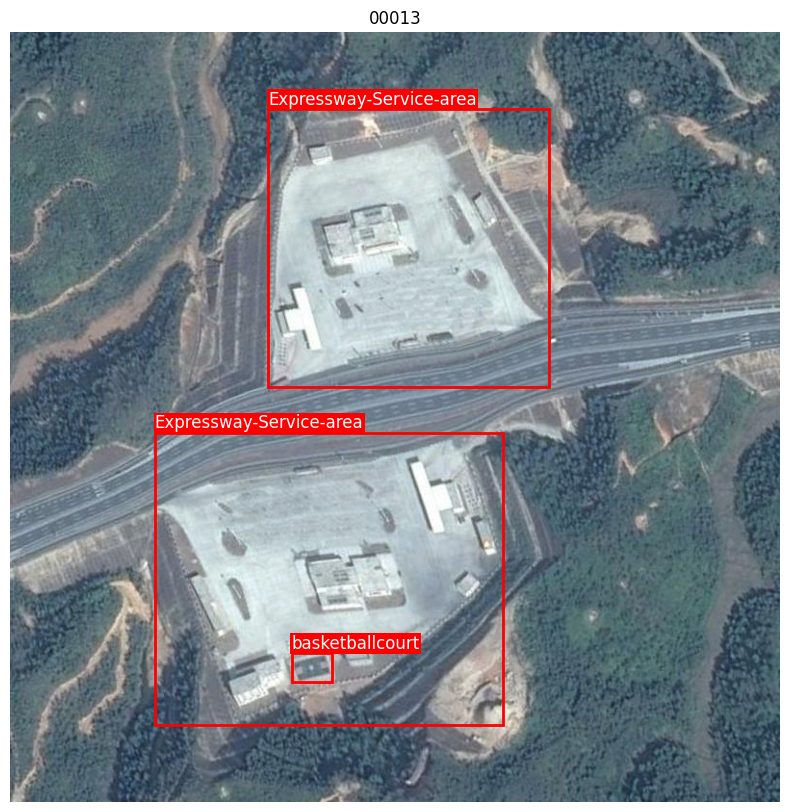

(800, 800)


In [25]:
with open(os.path.join(splits_dir, "clean_train.txt")) as f:
    image_ids = f.read().strip().split()

im = 5
image_id = image_ids[im].zfill(5)  
image_path = os.path.join(images_dir, image_id + ".jpg")
annotation_path = os.path.join(annotations_dir, image_id + ".xml")
show_image_with_boxes(image_path, annotation_path, image_id)

image = Image.open(image_path)
print(image.size)

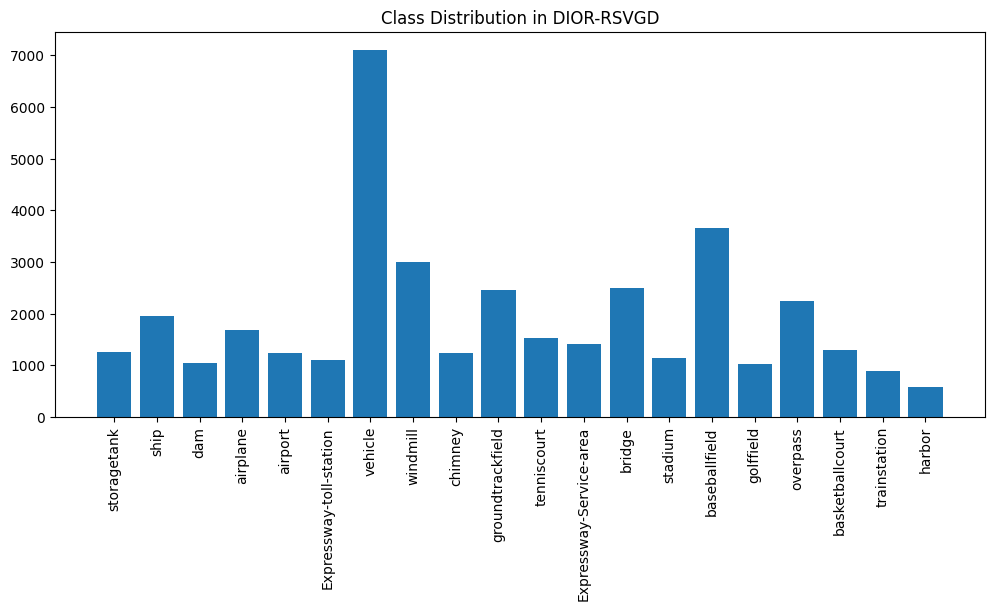

In [26]:
from collections import Counter

label_counter = Counter()

for xml_file in os.listdir(annotations_dir):
    objects = parse_annotation(os.path.join(annotations_dir, xml_file))
    for name, _ in objects:
        label_counter[name] += 1

# Plot class distribution
plt.figure(figsize=(12, 5))
plt.bar(label_counter.keys(), label_counter.values())
plt.xticks(rotation=90)
plt.title("Class Distribution in DIOR-RSVGD")
plt.show()


In [ ]:
from tqdm import tqdm
def move_grounding_caption_inside_object(annotations_dir):
    """
    For each XML file in annotations_dir, moves the <grounding_caption> element
    from the root to inside each <object> tag (copies the same caption to all objects).
    Overwrites the original XML files.
    """
    xml_files = [f for f in os.listdir(annotations_dir) if f.endswith('.xml')]
    for xml_file in tqdm(xml_files, desc="Processing XML files"):
        xml_path = os.path.join(annotations_dir, xml_file)
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Find and remove the root-level grounding_caption
        gc_elem = root.find("grounding_caption")
        if gc_elem is not None:
            gc_text = gc_elem.text
            root.remove(gc_elem)
        else:
            gc_text = None

        # Add grounding_caption inside each object
        for obj in root.findall("object"):
            # Remove any existing grounding_caption inside object
            old_gc = obj.find("grounding_caption")
            if old_gc is not None:
                obj.remove(old_gc)
            # Add new grounding_caption if available
            if gc_text:
                new_gc = ET.Element("grounding_caption")
                new_gc.text = gc_text
                obj.append(new_gc)

        tree.write(xml_path)


# move_grounding_caption_inside_object(f'{base_dir}/drive/MyDrive/DATASET/train_data/train_annotations')
# move_grounding_caption_inside_object(f'{base_dir}/drive/MyDrive/DATASET/test_data/test_annotations')
# move_grounding_caption_inside_object(f'{base_dir}/drive/MyDrive/DATASET/val_data/val_annotations')

Processing XML files: 100%|██████████| 1690/1690 [00:00<00:00, 2759.50it/s]


In [ ]:
import xml.etree.ElementTree as ET

def print_xml_tree(xml_file):
    """Prints the XML tree of an XML file.

    Args:
        xml_file: The path to the XML file.
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()

    def _print_element(element, level=0):
        """Recursively prints the element and its children."""
        indent = "  " * level
        print(f"{indent}<{element.tag}>")
        for child in element:
            _print_element(child, level + 1)
        print(f"{indent}</{element.tag}>")

    _print_element(root)

# Example usage
print_xml_tree(f"{base_dir}/drive/MyDrive/DATASET/train_data/train_annotations/00003.xml") # Replace with the actual path to your XML file

In [30]:
import xml.etree.ElementTree as ET

def extract_xml_data(xml_file):
    """Extracts and prints specific data from an XML file.

    Args:
        xml_file: The path to the XML file.
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Extract filename
    filename = root.find("filename").text
    print(f"Filename: {filename}")

    # Extract object name
    object_name = root.find("object/name").text
    print(f"Object Name: {object_name}")

    # Extract bounding box coordinates
    xmin = int(root.find("object/bndbox/xmin").text)
    ymin = int(root.find("object/bndbox/ymin").text)
    xmax = int(root.find("object/bndbox/xmax").text)
    ymax = int(root.find("object/bndbox/ymax").text)
    print(f"Bounding Box: (xmin={xmin}, ymin={ymin}, xmax={xmax}, ymax={ymax})")

    # Extract object description
    description = root.find("object/description").text
    print(f"Description: {description}")

# Example usage
extract_xml_data("Annotations/00001.xml")  # Replace with the actual path to your XML file

Filename: 00001.jpg
Object Name: golffield
Bounding Box: (xmin=133, ymin=237, xmax=684, ymax=672)
Description: A green and brown golf field


In [31]:
import xml.etree.ElementTree as ET

def print_xml_caption(xml_file):
    """Prints the 'caption' element of an XML file.

    Args:
        xml_file: The path to the XML file.
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()
    caption_element = root.find(".//description")  
    if caption_element is not None:
        caption_text = caption_element.text
        print(f"Caption: {caption_text}")
    else:
        print("Caption element not found in the XML file.")

# Example usage
print_xml_caption("Annotations/00001.xml")  # Replace with the actual path to your XML file

Caption: A green and brown golf field


# Shorten Captions for GroundingDINO

In [ ]:
import os
import openai
import xml.etree.ElementTree as ET
from tqdm import tqdm
import openai
from openai import OpenAI

from concurrent.futures import ThreadPoolExecutor, as_completed
import time

apikey = "api key..."
client = OpenAI(api_key=apikey)

def gpt_simplify_caption(caption):
    """
    Simplify a satellite image caption into a short grounding phrase
    using GPT-4 via OpenAI API. Keeps object names and spatial relationships.
    """
    prompt = (
       f"Take the long captions from the RSVG-DIOR dataset and rewrite them into short, precise captions suitable for a visual grounding model. Each caption should be clear, concise (under 10 words), and describe the main object(s) and their key attributes or actions, ensuring compatibility with object detection and grounding tasks. Maintain the original meaning while eliminating unnecessary details. Don't add anything that isn't present in the original input caption. For example: Original: 'A large red airplane is flying high above the blue ocean near a sandy beach.' Concise: 'Red airplane flying over ocean.' Provide the concise caption for the given input: {caption}"
    )

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": prompt}],
            max_tokens=50,
            temperature=0.2,
        )
        result = response.choices[0].message.content.strip()
        print(f"Original Caption: {caption}")
        print(f"GPT Output: {result}")
        return result
    except Exception as e:
        print(f"[ERROR] GPT API call failed: {e}")
        return "unknown object"

def add_grounding_caption_to_xml(xml_file, output_dir):
    """
    Adds a 'grounding_caption' entry to an XML annotation file and writes it to output_dir.
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Get existing caption (if any) or create a placeholder
    caption_element = root.find(".//description")
    if caption_element is None:
        caption_element = ET.Element("description")
        root.append(caption_element)
    caption = caption_element.text if caption_element.text else "Placeholder caption"

    # Shorten the caption using GPT (replace with your function)
    grounding_caption = gpt_simplify_caption(caption)

    # Add the grounding_caption element
    grounding_caption_element = ET.Element("grounding_caption")
    grounding_caption_element.text = grounding_caption
    root.append(grounding_caption_element)

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Write the modified XML to the output directory
    xml_filename = os.path.basename(xml_file)
    output_path = os.path.join(output_dir, xml_filename)
    tree.write(output_path)

# Example usage:
def process_xml_files_in_batches(xml_files, output_dir, batch_size=20, max_workers=5):
    """Processes XML files in batches using multithreading and saves them to a new directory.
    Skips files already present in output_dir.
    """
    os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist

    # Get set of already processed filenames in output_dir
    processed_files = set(f for f in os.listdir(output_dir) if f.endswith(".xml"))

    # Filter xml_files to only those not already processed
    files_to_process = [xml_file for xml_file in xml_files if os.path.basename(xml_file) not in processed_files]

    if not files_to_process:
        print("All XML files already processed in", output_dir)
        return

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for i in range(0, len(files_to_process), batch_size):
            batch = files_to_process[i:i + batch_size]
            futures = [executor.submit(add_grounding_caption_to_xml, xml_file, output_dir) for xml_file in batch]
            for future in as_completed(futures):
                future.result()  # Handle exceptions if needed
    print("Grounding captions added to XML files and saved to", output_dir)

# Example usage:
annotations_dir = "Annotations"  # Path to your annotations directory
output_dir = "Annotations2"  # Path to the output directory
xml_files = [os.path.join(annotations_dir, f) for f in os.listdir(annotations_dir) if f.endswith(".xml")]

start_time = time.time()
process_xml_files_in_batches(xml_files, output_dir)  # Process and save to Annotations2
end_time = time.time()

print(f"Processing time: {end_time - start_time:.2f} seconds")

## Description 

**Classes:** 20 

**Train Data:** 12340 images.

**Validation Data:** 1690 images.

**Test Data:** 3372 images. 



# Separate dataset in Train, Test, and Validation splits:

In [6]:
# ----- Train Set 
import shutil
from pathlib import Path

base_dir = Path('./')
images_dir = base_dir / "JPEGImages"
annotations_dir = base_dir / "Annotations2"

# Source file for train names
train_file = base_dir / 'clean_train.txt'

# Target folders for train data
train_images_dir = base_dir / 'train' / 'images'
train_annotations_dir = base_dir / 'train' / 'annotations'

# Create output folders
train_images_dir.mkdir(parents=True, exist_ok=True)
train_annotations_dir.mkdir(parents=True, exist_ok=True)

# Read and pad filenames
with train_file.open('r') as f:
    train_names = [line.strip().zfill(5) for line in f.readlines()]

print(f"Total train samples: {len(train_names)}")

# Copy files for train set
for name in train_names:
    img_src = images_dir / f"{name}.jpg"
    xml_src = annotations_dir / f"{name}.xml"

    img_dst = train_images_dir / f"{name}.jpg"
    xml_dst = train_annotations_dir / f"{name}.xml"

    if img_src.exists():
        shutil.copy(img_src, img_dst)
    else:
        print(f"[WARNING] Missing image: {img_src}")

    if xml_src.exists():
        shutil.copy(xml_src, xml_dst)
    else:
        print(f"[WARNING] Missing annotation: {xml_src}")


Total train samples: 12340


In [ ]:
# ----- Test Set 

# Source file for test names
test_file = base_dir / 'clean_test.txt'

# Target folders for test data
test_images_dir = base_dir / 'test' / 'images'
test_annotations_dir = base_dir / 'test' / 'annotations'

# Create output folders
test_images_dir.mkdir(parents=True, exist_ok=True)
test_annotations_dir.mkdir(parents=True, exist_ok=True)

# Read and pad filenames
with test_file.open('r') as f:
    test_names = [line.strip().zfill(5) for line in f.readlines()]

print(f"Total test samples: {len(test_names)}")

# Copy files for test set
for name in test_names:
    img_src = images_dir / f"{name}.jpg"
    xml_src = annotations_dir / f"{name}.xml"

    img_dst = test_images_dir / f"{name}.jpg"
    xml_dst = test_annotations_dir / f"{name}.xml"

    if img_src.exists():
        shutil.copy(img_src, img_dst)
    else:
        print(f"[WARNING] Missing image: {img_src}")

    if xml_src.exists():
        shutil.copy(xml_src, xml_dst)
    else:
        print(f"[WARNING] Missing annotation: {xml_src}")


Total test samples: 3372


In [8]:
# ----- Validation Set

# Source file for validation names
val_file = base_dir / 'val.txt'

# Target folders for validation data
val_images_dir = base_dir / 'val' / 'images'
val_annotations_dir = base_dir / 'val' / 'annotations'

# Create output folders
val_images_dir.mkdir(parents=True, exist_ok=True)
val_annotations_dir.mkdir(parents=True, exist_ok=True)

# Read and pad filenames
with val_file.open('r') as f:
    val_names = [line.strip().zfill(5) for line in f.readlines()]

print(f"Total validation samples: {len(val_names)}")

# Copy files for validation set
for name in val_names:
    img_src = images_dir / f"{name}.jpg"
    xml_src = annotations_dir / f"{name}.xml"

    img_dst = val_images_dir / f"{name}.jpg"
    xml_dst = val_annotations_dir / f"{name}.xml"

    if img_src.exists():
        shutil.copy(img_src, img_dst)
    else:
        print(f"[WARNING] Missing image: {img_src}")

    if xml_src.exists():
        shutil.copy(xml_src, xml_dst)
    else:
        print(f"[WARNING] Missing annotation: {xml_src}")



Total validation samples: 3829
[WARNING] Missing image: JPEGImages/00002.jpg
[WARNING] Missing annotation: Annotations2/00002.xml
[WARNING] Missing image: JPEGImages/00009.jpg
[WARNING] Missing annotation: Annotations2/00009.xml
[WARNING] Missing image: JPEGImages/00119.jpg
[WARNING] Missing annotation: Annotations2/00119.xml
[WARNING] Missing image: JPEGImages/00171.jpg
[WARNING] Missing annotation: Annotations2/00171.xml
[WARNING] Missing image: JPEGImages/00192.jpg
[WARNING] Missing annotation: Annotations2/00192.xml
[WARNING] Missing image: JPEGImages/00231.jpg
[WARNING] Missing annotation: Annotations2/00231.xml
[WARNING] Missing image: JPEGImages/00232.jpg
[WARNING] Missing annotation: Annotations2/00232.xml
[WARNING] Missing image: JPEGImages/00248.jpg
[WARNING] Missing annotation: Annotations2/00248.xml
[WARNING] Missing image: JPEGImages/00339.jpg
[WARNING] Missing annotation: Annotations2/00339.xml
[WARNING] Missing image: JPEGImages/00393.jpg
[WARNING] Missing annotation: An